<a href="https://colab.research.google.com/github/shinnew9/Apziva_practice_code/blob/main/Project4-MonReader/1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MonReader
- help people with visually impaired (for blind people), they need somebody to read them
- A mobile application: read + flip the pages (automatically?) + stop the recording

<br>
- Goal: to detect which pages are being flipped / which pages aren't
Prediction pages that are not being flipped
<br>
- OCR (Optical Character Recognition):  extract text from the still images also extract text from the images + synthensize audio + speech,
so that blind people can actually listen to the contents of the book
<br>
- 3 steps of the project:
0. EDA,
1. page flipping with basic CNN
 - basic CNN (different CNN architecture), transfer learning + pretrainin models as well
2. OCR
3. Speech Synthesize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing Necessary Packages

In [ ]:
!pip install ace_tools --quiet

In [ ]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 143.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Unzip and Open images

In [ ]:
import zipfile
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image

# Define path
zip_path = "/content/drive/MyDrive/Apziva/4th_MonReader/images.zip"
extract_dir = "/content/drive/MyDrive/Apziva/4th_MonReader/monreader_images"

os.makedirs(extract_dir, exist_ok = True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check directory structure after extraction
training_path = os.path.join(extract_dir, "images", "training")
test_path = os.path.join(extract_dir, "images", "testing")

# Checking the nu
training_images = glob(os.path.join(training_path, "**", "*.jpg"), recursive=True)
test_images = glob(os.path.join(test_path, "**", "*.jpg"), recursive=True)

print(f"🖼️ Training images found: {len(training_images)}")
print(f"🖼️ Testing images found: {len(test_images)}")

🖼️ Training images found: 2392
🖼️ Testing images found: 597


In [ ]:
extract_dir = "/content/drive/MyDrive/Apziva/4th_MonReader/monreader_images"

# Check directory structure after extraction
training_path = os.path.join(extract_dir, "images", "training")
test_path = os.path.join(extract_dir, "images", "testing")

# Checking the nu
training_images = glob(os.path.join(training_path, "**", "*.jpg"), recursive=True)
test_images = glob(os.path.join(test_path, "**", "*.jpg"), recursive=True)

print(f"🖼️ Training images found: {len(training_images)}")
print(f"🖼️ Testing images found: {len(test_images)}")

🖼️ Training images found: 2392
🖼️ Testing images found: 597


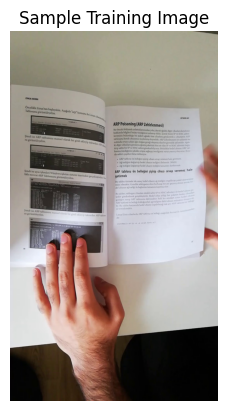

In [ ]:
# sample image
from PIL import Image
import matplotlib.pyplot as plt

if training_images:
  img = Image.open(training_images[0])
  plt.imshow(img)
  plt.title("Sample Training Image")
  plt.axis("off")
  plt.show()
else:
  print("⚠️ No training images found.")

### EDA

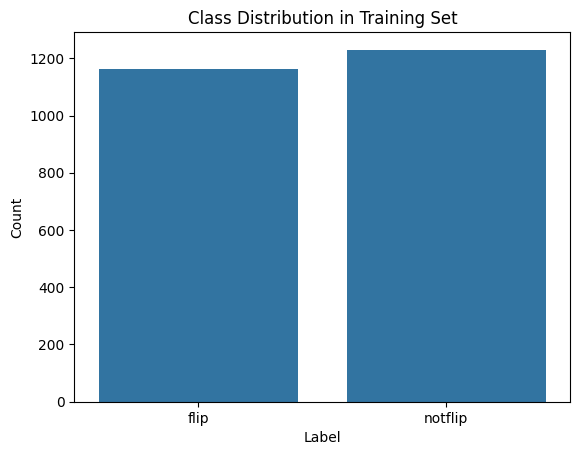

In [ ]:
# 1. Distribution of each classes

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df_train["label"])
plt.title("Class Distribution in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

100%|██████████| 200/200 [00:00<00:00, 547.82it/s]


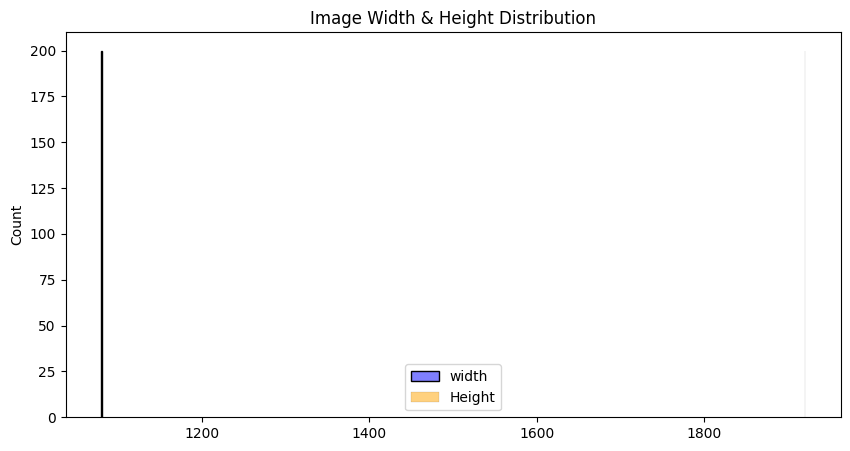

In [ ]:
### 2. Distribution of Image Resoultion
from PIL import Image
from tqdm import tqdm

sizes = []
for path in tqdm(df_train["filepath"][:200]):   # might be slow
  with Image.open(path) as img:
    sizes.append(img.size)

widths, heights = zip(*sizes)

plt.figure(figsize=(10, 5))
sns.histplot(widths, color='blue', label='width', kde=True)
sns.histplot(heights, color='orange', label='Height', kde=True)
plt.title("Image Width & Height Distribution")
plt.legend()
plt.show()


# I will get back to you

Counter({(1080, 1920): 200})


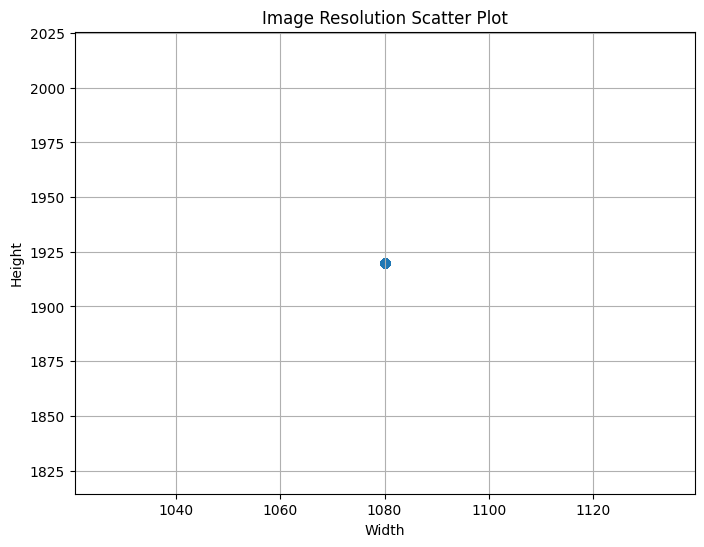

In [ ]:
from collections import Counter

print(Counter(sizes))  # Counter({(1080, 1920): 200})

plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Scatter Plot")
plt.grid(True)
plt.show()

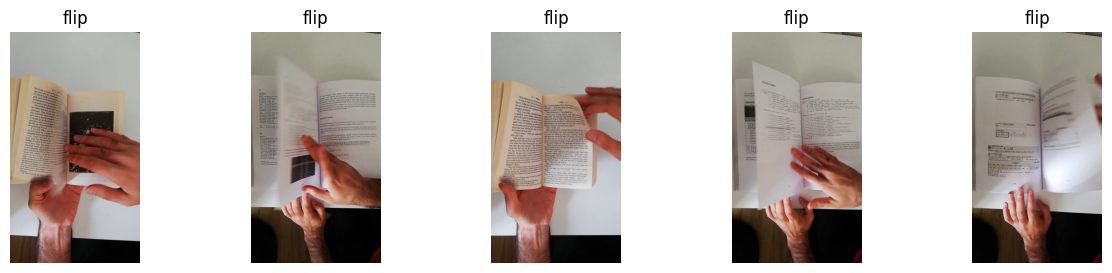

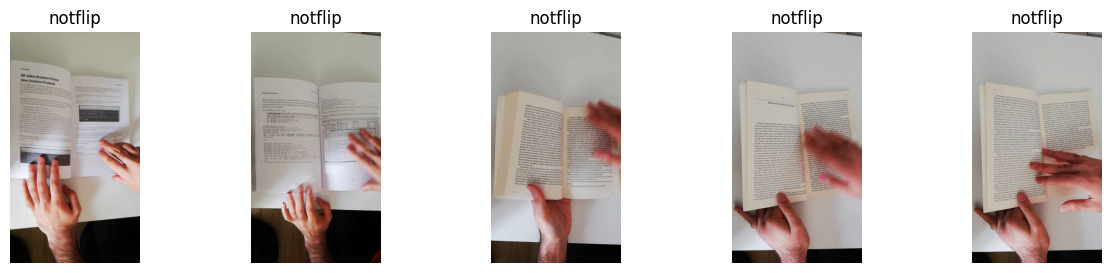

In [ ]:
### 3. Flip and NotFlip images


import random
from PIL import Image

def show_random_images(label, num=5):
  subset = df_train[df_train["label"] == label].sample(num)
  plt.figure(figsize=(15, 3))
  for i, path in enumerate(subset["filepath"]):
    img = Image.open(path)
    plt.subplot(1, num, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
  plt.show()

show_random_images("flip")
show_random_images("notflip")

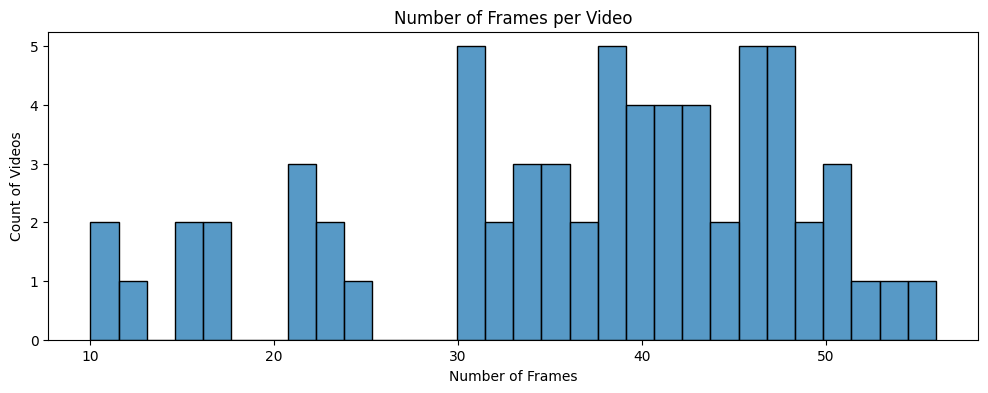

In [ ]:
### 4.Distribution of Vide frames

df_train["video_id"] = df_train["filepath"].apply(lambda x: os.path.basename(x).split("_")[0])

video_counts = df_train["video_id"].value_counts()
plt.figure(figsize=(12, 4))
sns.histplot(video_counts, bins=30)
plt.title("Number of Frames per Video")
plt.xlabel("Number of Frames")
plt.ylabel("Count of Videos")
plt.show()

In [ ]:
### 5. Checking whether there are any damaged files
corrupted = []
for path in tqdm(df_train["filepath"]):
  try:
    img = Image.open(path)
    img.verify()
  except:
    corrupted.append(path)

print(f"❌ Corrupted files: {len(corrupted)}")

100%|██████████| 2392/2392 [00:04<00:00, 545.91it/s]

❌ Corrupted files: 0


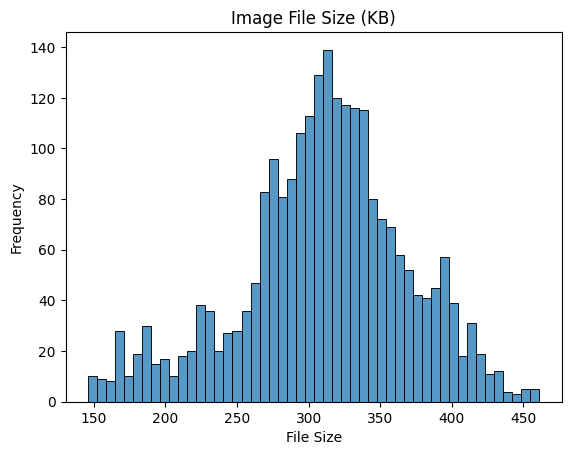

In [ ]:
# chekcing the size of each image file

df_train["size_kb"] = df_train["filepath"].apply(lambda x:os.path.getsize(x) // 1024 )
sns.histplot(df_train["size_kb"], bins=50)
plt.title("Image File Size (KB)")
plt.xlabel("File Size")
plt.ylabel("Frequency")
plt.show()

### CNN Baseline model

In [ ]:
def get_label_from_path(path):
  return "flip" if "/flip/" in path else "notflip"

df_train = pd.DataFrame({
    "filepath": training_images,
    "label": [get_label_from_path(p) for p in training_images]
})

df_test = pd.DataFrame({
    "filepath": test_images,
    "label": [get_label_from_path(p) for p in test_images]
})

print(df_train.head())

                                            filepath label
0  /content/drive/MyDrive/Apziva/4th_MonReader/mo...  flip
1  /content/drive/MyDrive/Apziva/4th_MonReader/mo...  flip
2  /content/drive/MyDrive/Apziva/4th_MonReader/mo...  flip
3  /content/drive/MyDrive/Apziva/4th_MonReader/mo...  flip
4  /content/drive/MyDrive/Apziva/4th_MonReader/mo...  flip


In [ ]:
### Torch Dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Image Size and transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

class FlipDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df.reset_index(drop=True)
    self.transform = transform
    self.label_map = {"flip": 1, "notflip": 0}

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_path = self.df.loc[idx, "filepath"]
    label = self.label_map[self.df.loc[idx, "label"]]
    image = Image.open(img_path).convert("RGB")
    if self.transform:
      image = self.transform(image)
    return image, label

train_dataset = FlipDataset(df_train, transform=transform)
test_dataset = FlipDataset(df_test, transform=transform)

In [ ]:
### Simple CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
  def __init__(self):
    super(BasicCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
    self.fc1 = nn.Linear(32*30*30, 64)
    self.fc2 = nn.Linear(64, 1)  # binary classification

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))   # -> [B, 16, 63, 63]
    x = self.pool(F.relu(self.conv2(x)))   # -> [B, 32, 30, 30]
    x = x.view(-1, 32*30*30)
    x = F.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    return x

In [ ]:
### Training loop and run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# initialize dataloader with train_dataset
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)


# Training loop
for epoch in range(3):   # Increase later
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.float().unsqueeze(1).to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 41.7149
Epoch 2, Loss: 16.6743
Epoch 3, Loss: 10.1311


In [ ]:
### Evaluation
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predicted = (outputs > 0.5).int().squeeze(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 94.14%


### Trying OCR

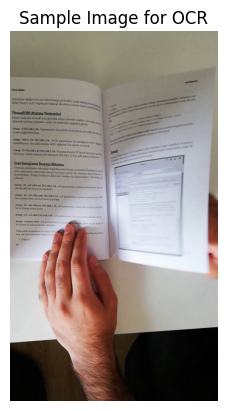

📝 Detected: (IAKLans (confidence: 0.09)
📝 Detected: serverlenn (confidence: 0.25)
📝 Detected: Ve hu (confidence: 0.33)
📝 Detected: servi lerln hangi portlardan (confidence: 0.43)
📝 Detected: doluyt (confidence: 0.42)
📝 Detected: Jcuk (confidence: 0.16)
📝 Detected: kpal port bularak da Islellm (confidence: 0.40)
📝 Detected: 0ag1 (confidence: 0.30)
📝 Detected: FirewalVIDS Atlatma Yintemleri (confidence: 0.67)
📝 Detected: Hedel makinede firewall yanl guvcnlik duvari devrede (confidence: 0.40)
📝 Detected: whatmak Icin bazx yontemler vardir Iu yontemler = (confidence: 0.38)
📝 Detected: olabilir (confidence: 0.72)
📝 Detected: f@sogidaki gibidir (confidence: 0.17)
📝 Detected: nnap -{ 192.168.4.3: (paramelresi Ic pakctlerl (confidence: 0.16)
📝 Detected: 'parcuayp (confidence: 0.25)
📝 Detected: masnt saBlayabilininiz (confidence: 0.19)
📝 Detected: Buvenlik- (confidence: 0.21)
📝 Detected: ninp (confidence: 0.23)
📝 Detected: MTU 576 192,.169.1.34: -MTU parantelresl Ile (confidence: 0.29)
📝 Detect

In [ ]:
import easyocr
import os
from PIL import Image
import matplotlib.pyplot as plt

reader = easyocr.Reader(['en'])

# Access to the single image foile
sample_image_path = ('/content/drive/MyDrive/Apziva/4th_MonReader/monreader_images/images/training/flip/0001_000000010.jpg')

# Sample Image print
img = Image.open(sample_image_path)
plt.imshow(img)
plt.axis("off")
plt.title("Sample Image for OCR")
plt.show()

# Implementing OCR
result = reader.readtext(sample_image_path)

# Pringting out text
for bbox, text, conf in result:
  print(f"📝 Detected: {text} (confidence: {conf:.2f})")